In [1]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)


import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import scipy as sp
import theano.tensor as t

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("../Data/cns_data.csv")
rf_results = pd.read_csv("Outputs/rf_results.csv")

In [3]:
var = rf_results
#Keep only what we are using
var = var.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','diag']]
var = var.dropna()
var.shape

(361, 48)

In [4]:
y = var['diag']
y[y==5] = 2
y[y==4] = 2
y[y==3] = 2
#x = var[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = var[['CMalaria','sbp','glasgtot','dbp','resp','card','weight','height','muac']]

In [5]:
import theano.tensor as tt
softmax = tt.nnet.softmax

In [6]:
x.shape[1]

9

In [6]:
with pm.Model() as logistic_model:
    μ = pm.Normal('μ', 0, sd=10, shape=(3))
    effects = pm.Normal('effects', mu=0, sd=10, shape=(x.shape[1], 3))
    
    # expected parameter
    p = softmax(μ + t.dot(x, effects)) # try softmax transformation
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Categorical('Y_obs', p=p, observed=y)

with logistic_model:
    trace = pm.sample(1000, tune=1000, njobs=2, nuts_kwargs={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [effects, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [12:14<00:00,  2.63draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9648418668468449, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


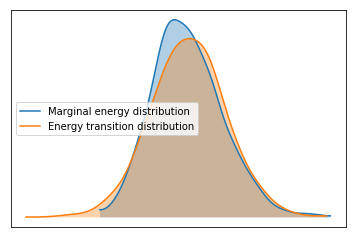

In [7]:
pm.energyplot(trace)

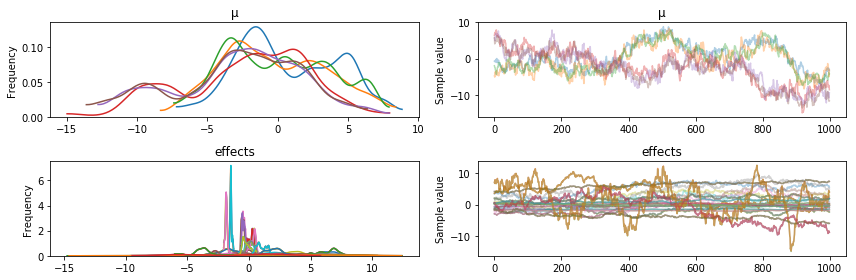

In [8]:
pm.traceplot(trace);

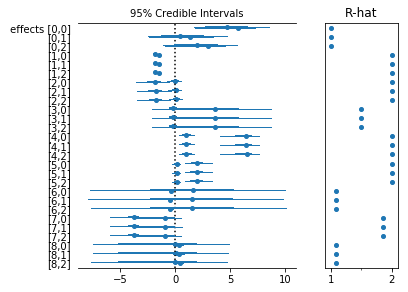

In [9]:
pm.forestplot(trace, varnames=['effects'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114404c50>,
      dtype=object)

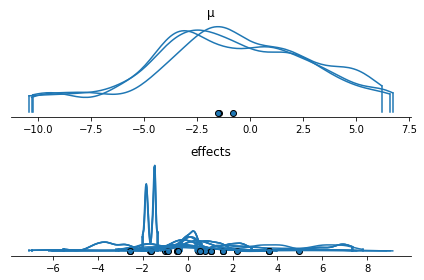

In [10]:
pm.plots.densityplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x113e8db70>,
      dtype=object)

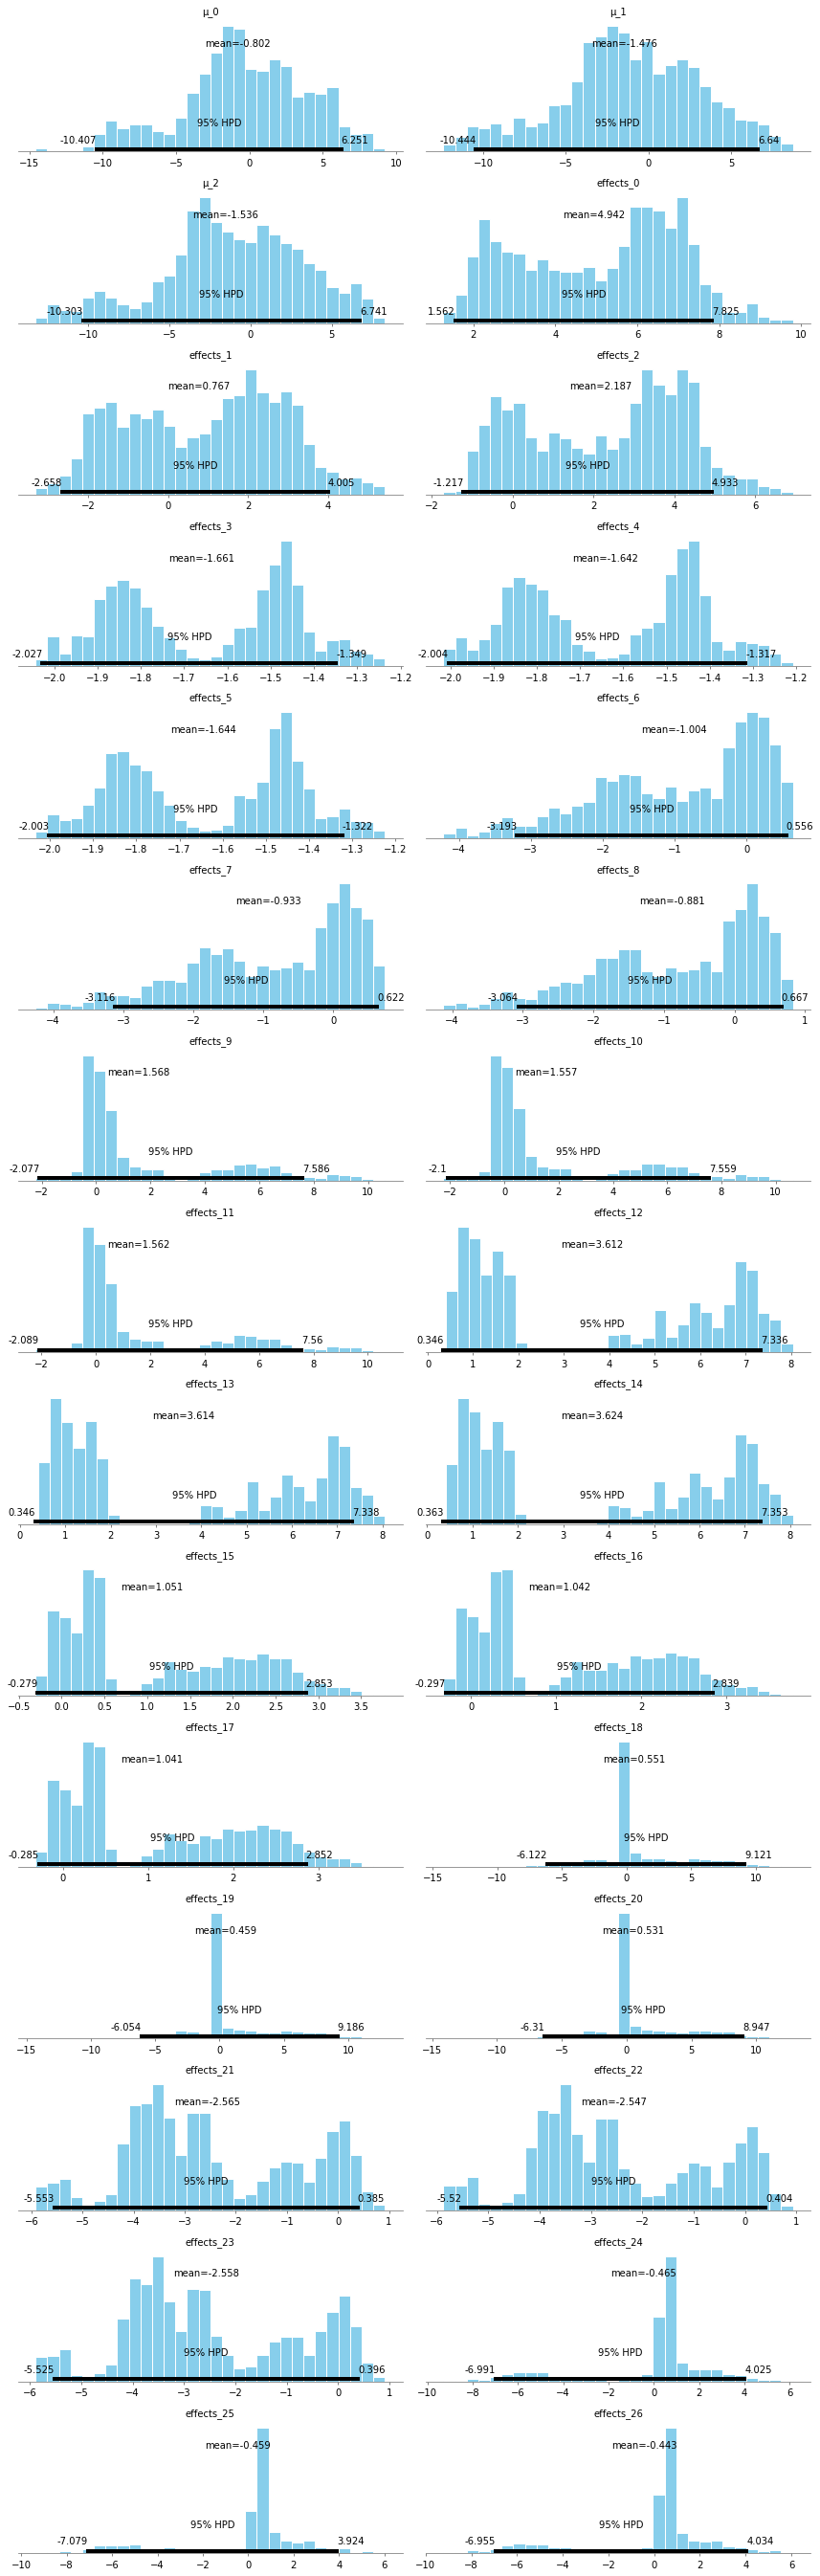

In [39]:
pm.plots.plot_posterior(trace)

In [11]:
ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)

100%|██████████| 500/500 [00:16<00:00, 31.02it/s]


In [12]:
ppc['Y_obs'].shape

(500, 361, 1)

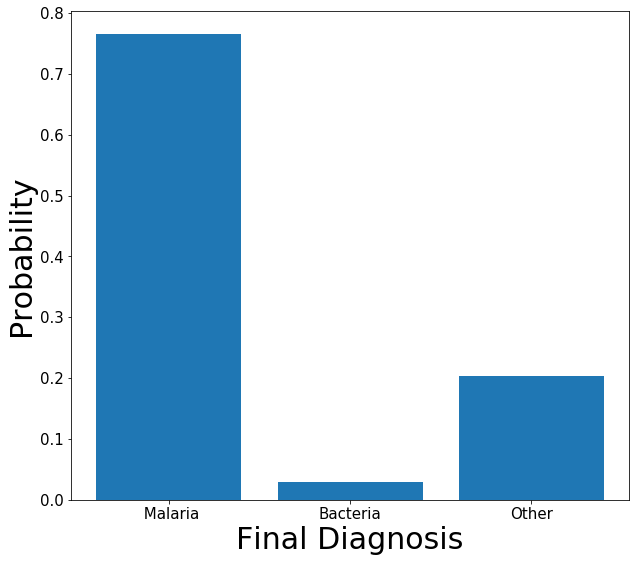

In [58]:
#ppc for person 0

plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,0,0] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,0,0] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,0,0] == 2) / 500)], width=0.8)

plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Diagnosis", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

In [126]:
result = pd.DataFrame({'diag':y})
result['p_mal'] = np.sum(ppc['Y_obs'][:,:,0] == 0, axis = 0) / 500
result['p_bact'] = np.sum(ppc['Y_obs'][:,:,0] == 1, axis = 0) / 500
result['p_other'] = np.sum(ppc['Y_obs'][:,:,0] == 2, axis = 0) / 500
result['p_max'] = np.amax(result.drop(['diag'], axis=1), axis = 1)
result['prediction'] = 0
result['prediction'][np.where(result['p_max'] == result['p_bact'], 'yes', 'no') == 'yes'] = 1
result['prediction'][np.where(result['p_max'] == result['p_other'], 'yes', 'no') == 'yes'] = 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
result

,diag,p_mal,p_bact,p_other,p_max,prediction
0,0.0,0.810,0.024,0.166,0.810,0
1,0.0,0.852,0.018,0.130,0.852,0
2,2.0,0.708,0.020,0.272,0.708,0
3,0.0,0.784,0.018,0.198,0.784,0
4,0.0,0.732,0.032,0.236,0.732,0
5,0.0,0.672,0.032,0.296,0.672,0
6,0.0,0.070,0.252,0.678,0.678,2
7,1.0,0.056,0.352,0.592,0.592,2
8,0.0,0.858,0.018,0.124,0.858,0
9,1.0,0.040,0.202,0.758,0.758,2


In [128]:
sum(result['diag'] == result['prediction'])

242

In [33]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ__0,-4.14,2.93,0.29,-9.98,-0.62,2.21,1.57
μ__1,-5.48,3.14,0.31,-11.05,-1.28,1.69,1.86
μ__2,-5.06,3.20,0.32,-10.96,-1.17,1.92,1.70
effects__0_0,1.55,1.10,0.11,-0.56,3.76,13.77,1.07
effects__0_1,-2.81,1.15,0.11,-4.84,-0.48,13.91,1.06
effects__0_2,-1.23,1.06,0.10,-3.06,1.07,14.39,1.08
effects__1_0,-1.34,0.50,0.05,-1.90,-0.63,1.04,6.66
effects__1_1,-1.32,0.51,0.05,-1.88,-0.61,1.04,6.63
effects__1_2,-1.33,0.50,0.05,-1.88,-0.60,1.04,6.64
effects__2_0,-0.37,0.60,0.06,-1.51,0.25,2.59,1.54


In [39]:
y

0      0.0
1      0.0
2      2.0
3      0.0
4      0.0
5      0.0
6      0.0
7      1.0
8      0.0
9      1.0
10     1.0
11     2.0
12     0.0
13     2.0
14     1.0
15     2.0
16     1.0
17     2.0
18     2.0
19     2.0
20     2.0
21     2.0
22     0.0
23     2.0
24     0.0
25     1.0
26     2.0
27     2.0
28     2.0
29     0.0
      ... 
331    2.0
332    1.0
333    2.0
334    0.0
335    0.0
336    0.0
337    1.0
338    2.0
339    0.0
340    2.0
341    2.0
342    2.0
343    2.0
344    2.0
345    0.0
346    2.0
347    2.0
348    0.0
349    1.0
350    0.0
351    2.0
352    1.0
353    0.0
354    1.0
355    0.0
356    2.0
357    1.0
358    0.0
359    2.0
360    2.0
Name: diag, Length: 361, dtype: float64

In [4]:
data

Unnamed: 0 surnamenam patientreg  siteincl  ident patinit mothinit  \
0             0        K-E      13509       1.0      1     T-A      N-M   
1             1        K-E      13640       NaN      2     A-A      M-I   
2             2        T-D      13685       NaN      3     A-B      K-S   
3             3        Z-J      13637       1.0      4     A-O      K-D   
4             4        K-P      13719       1.0      5     K-B      T-J   
5             5        K-P      13689       NaN      6     A-H      N-M   
6             6        K-P      13822       1.0      7     N-P      K-J   
7             7        K-P      13815       NaN      8     N-J      N-E   
8             8        Z-J      13905       NaN      9     A-R      O-S   
9             9        K-P      13919       NaN     10     T-S      K-A   
10           10        Z-J      13857       NaN     11     A-E      N-G   
11           11        T-D      13643       NaN     12     Q-E      M-J   
12           12        K-P      13978       NaN     13     T-E      T-A   
13           13        K-P      14036       NaN     14     A-A      K-A   
14           14        K-P      14049       NaN     15     N-B      N-S   
15           15        Z-J      14129       NaN     16     A-L      E-L   
16           16        K-P      14126       NaN     17     A-C      G-A   
17           17        T-D      14082       1.0     18     A-B      K-A   
18           18        K-P      14164       NaN     19     N-J      M-S   
19           19        T-D      14158       NaN     20     O-G      M-S   
20           20        T-D      14157       1.0     21     N-G      M-S   
21           21        T-D      14150       NaN     22     N-J      K-B   
22           22        T-D      14137       NaN     23     N-D      T-A   
23           23        T-D      14179       NaN     24     N-R      M-J   
24           24        T-D      14210       NaN     25     T-J      T-D   
25           25        T-D      14317       NaN     26     M-A      K-J   
26           26        T-D      14432       1.0     27     A-S      F-K   
27           27        K-P      14476       NaN     28     A-C      A-R   
28           28        Z-J      14537       NaN     29     A-I      B-J   
29           29        T-D      14639       1.0     30     A-A      K-G   
..          ...        ...        ...       ...    ...     ...      ...   
450         450        K-E      10258       1.0    451     A-C      K-M   
451         451        K-E      10255       1.0    452     S-C      N-M   
452         452        453      10290       1.0    453     M-M      T-K   
453         453        M-K    8816HIC       2.0    454     S-A      K-H   
454         454        K-E      10224       1.0    455     O-J      N-P   
455         455        K-E      10145       1.0    456     K-E      N-R   
456         456        K-E      10139       1.0    457     N-G      A-S   
457         457        M-K    1008H12       2.0    458     A-L      A-A   
458         458        M-K      10368       1.0    459     A-E      K-J   
459         459        M-K    12H1085       2.0    460     A-D      M-N   
460         460        K-E      10214       1.0    461     K-R      G-O   
461         461        N-D      10452       1.0    462     M-N      N-E   
462         462        M-K     12HICH       2.0    463     A-I      B-S   
463         463        K-E      10409       1.0    464     A-B      T-D   
464         464        K-E      10721       1.0    465     N-S      K-P   
465         465        K-E      10785       1.0    466     N-A      A-J   
466         466        K-E      10779       1.0    467     N-A      N-S   
467         467        K-E      10864       1.0    468     N-C      T-J   
468         468        N-D      10723       1.0    469     A-N      A-K   
469         469        N-D      10850       1.0    470     A-A      N-L   
470         470        K-E      10890       1.0    471     A-M      N-P   
471         471        K-E    

Questions:
    Abstract
    How to create probabilistic output for individual predictions
    Is sensitivity/specificity a decent metric, what about unsureness?